# Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly 
import ccxt
import talib

# Инструменты для работы с БД
from utils import influxdb_communication, candel_patterns

# Настройка начальной работы с InfluxDB

Если в вашей БД нет данных, то воспользуйтесь коммандой ниже. Она скачает котировку BTC/USDT с таймфреймами: ```15m, 30m, 1h, 2h, 4h, 8h, 12h, 1d```

Другие таймфреймы на данный момент не доступны

In [2]:
#influxdb_communication.create_all_timeframes_data("BTC/USDT")

Если при записи у вас что то пошло не так или по другим причинам данные в БД стали плохими, то воспользуйтесь коммандой ниже, чтобы дропнуть бакет с данными

In [3]:
#influxdb_communication.delete_all_data()

Если происходит ошибка, то поочередёно удаляйте все mesurments из бакета

In [4]:
#influxdb_communication.delete_measurement("yours_mesurments")

# Чтение данных из InfluxDB

Внимание, переменная ```TIMEFRAME_FOR_STRATEGY``` будет использоваться на всём протяжении первичного исследования

In [5]:
TIMEFRAME_FOR_STRATEGY = "12h"

In [6]:
ohlcv = influxdb_communication.read_data("BTC/USDT", TIMEFRAME_FOR_STRATEGY)

In [7]:
ohlcv

,Date,Close,High,Low,Open,Volume
0,2017-08-17 12:00:00+00:00,4285.08,4485.39,4200.74,4436.06,649.441630
1,2017-08-18 00:00:00+00:00,4340.31,4371.52,4134.61,4285.08,720.722201
2,2017-08-18 12:00:00+00:00,4108.37,4340.31,3938.77,4320.52,479.166063
3,2017-08-19 00:00:00+00:00,3957.60,4184.69,3850.00,4108.37,298.518569
4,2017-08-19 12:00:00+00:00,4139.98,4149.99,3928.89,3945.12,82.791194
...,...,...,...,...,...,...
5150,2024-09-05 00:00:00+00:00,56698.01,58327.07,56541.68,57970.90,10880.572200
5151,2024-09-05 12:00:00+00:00,56180.00,57350.00,55643.65,56698.01,16926.341930
5152,2024-09-06 00:00:00+00:00,55999.09,56858.88,55280.00,56180.00,13149.266980
5153,2024-09-06 12:00:00+00:00,53962.97,57008.00,52550.00,55999.09,41298.501280


# Созданиие стратегии

Торговая стратегия будет заключатся в простом агрегировании данных о паттернов с помощью скользящего окна по времени. Данные из окон будут суммироватся, что и будет нашим индикатором по которому мы будем строить стратегию. На основе значений индикатора будут созданы два thresholda, которые будут определять точку открытия long позиции и закрытия long позиции. Стратегия бдет торговать на спотовом рынке, по этому short позиции не будут открываться

## Рассчёт паттернов тех. анализа

In [8]:
ohlcv = candel_patterns.add_all_caldel_patterns(ohlcv)

In [9]:
ohlcv.head()

,Date,Close,High,Low,Open,Volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
0,2017-08-17 12:00:00+00:00,4285.08,4485.39,4200.74,4436.06,649.441630,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-08-18 00:00:00+00:00,4340.31,4371.52,4134.61,4285.08,720.722201,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-08-18 12:00:00+00:00,4108.37,4340.31,3938.77,4320.52,479.166063,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-08-19 00:00:00+00:00,3957.60,4184.69,3850.00,4108.37,298.518569,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-08-19 12:00:00+00:00,4139.98,4149.99,3928.89,3945.12,82.791194,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Сохранение результатов в БД

In [10]:
influxdb_communication.add_caldel_patterns_data(ohlcv, "BTC/USDT", TIMEFRAME_FOR_STRATEGY)

## Агрегация результатов

После того, как мы получили информацию о том куда будет двигаться тренд с помощью паттернов на основе свечей их надо как-то агрегировать. Для этого в InfluxDB пройдёмся с помощью Flux скрипта с помощью скользящего окна и проссумируем значения по паттернам тех. анализа

In [11]:
WINDOW_PERIOD = "12d"
WINDOW_EVERY = "4d"

In [12]:
# window.every - сдвиг окна по отношению к началу прошлого (WINDOW_PERIOD)
# window.period - время в промежутке еоторого будут агрегироваться данные (WINDOW_EVERY)
query = f'''
from(bucket: "{influxdb_communication.INFLUXDB_BUCKET}")
  |> range(start: -inf)
  |> filter(fn: (r) => r._measurement == "BTC/USDT_{TIMEFRAME_FOR_STRATEGY}_candel_patterns")
  |> window(period: {WINDOW_PERIOD}, every: {WINDOW_EVERY})
  |> sum()
  |> group(columns: ["_start"], mode: "by")
  |> sum(column: "_value")
  //|> pivot(rowKey: ["_start"], columnKey: ["_start"], valueColumn: "_value")
'''

In [13]:
patterns_result = influxdb_communication.query_df(query)

In [14]:
patterns_result.head(10)

,result,table,_start,_value
0,_result,0,2017-08-06 00:00:00+00:00,0
1,_result,1,2017-08-10 00:00:00+00:00,2
2,_result,2,2017-08-14 00:00:00+00:00,5
3,_result,3,2017-08-18 00:00:00+00:00,18
4,_result,4,2017-08-22 00:00:00+00:00,22
5,_result,5,2017-08-26 00:00:00+00:00,23
6,_result,6,2017-08-30 00:00:00+00:00,7
7,_result,7,2017-09-03 00:00:00+00:00,-1
8,_result,8,2017-09-07 00:00:00+00:00,-1
9,_result,9,2017-09-11 00:00:00+00:00,12


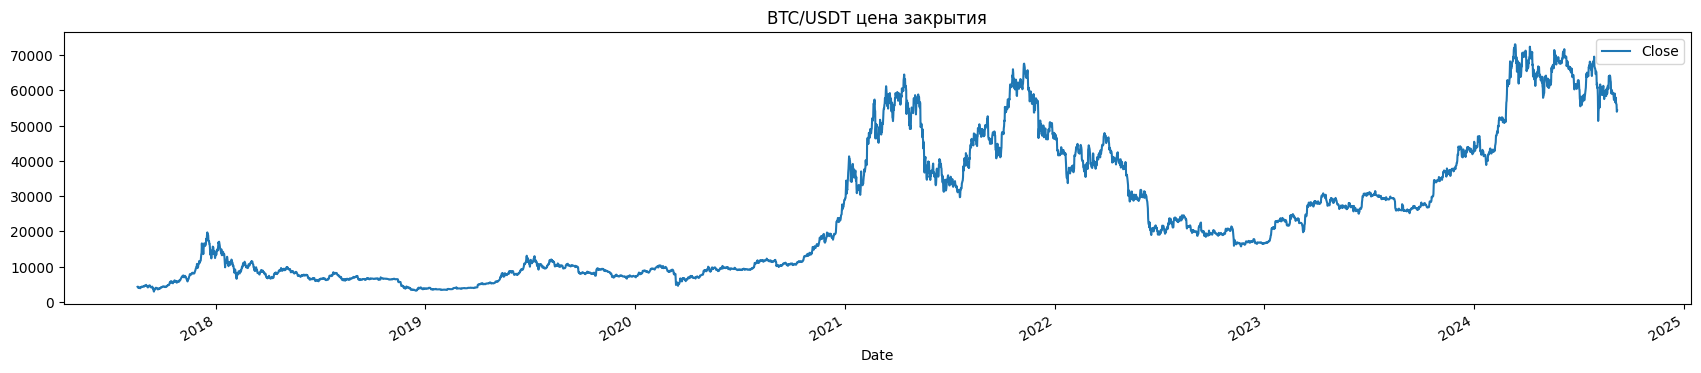

In [15]:
ohlcv.plot(x="Date", y="Close", figsize=(21, 4), title="BTC/USDT цена закрытия")
plt.show()

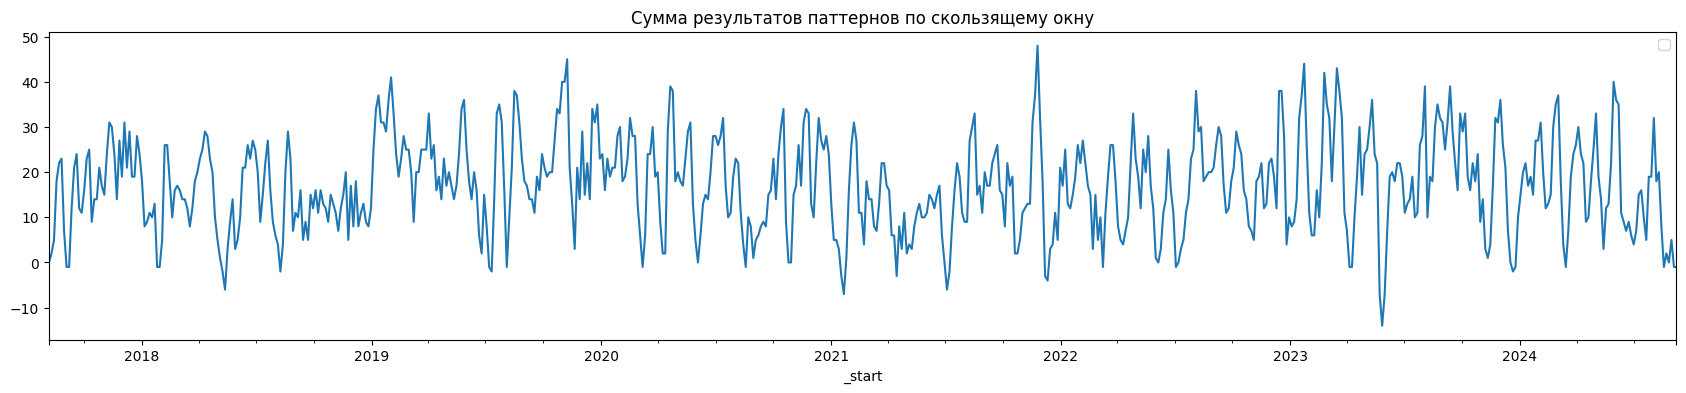

In [16]:
patterns_result.plot(x="_start", y="_value", figsize=(21, 4), title="Сумма результатов паттернов по скользящему окну")
plt.show()

В результате мы сагрегировали результаты, которые были получены в результате детекции паттернов тех. анализа. Далее на основе этих данных будет разрабатываться алгоритм стратегии.

## Анализ полученных данных

In [17]:
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.gofplots import qqplot

### Анализ данных пары BTC/USDT

In [18]:
btcusdt_close = ohlcv["Close"]
btcusdt_return = ohlcv["Close"].diff()
btcusdt_log_return = np.log(ohlcv["Close"]).diff()

#### Визуализация данных

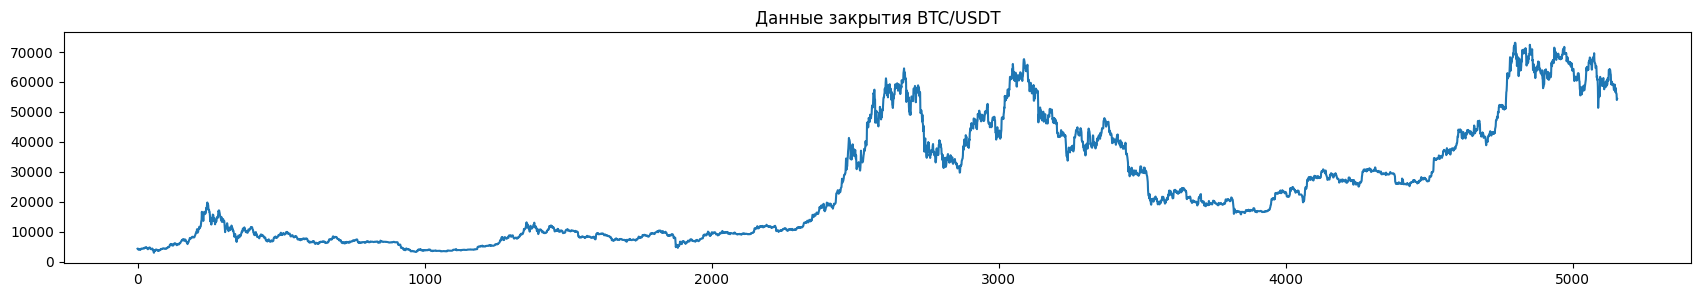

In [19]:
btcusdt_close.plot(figsize=(21, 3), title="Данные закрытия BTC/USDT")
plt.show()

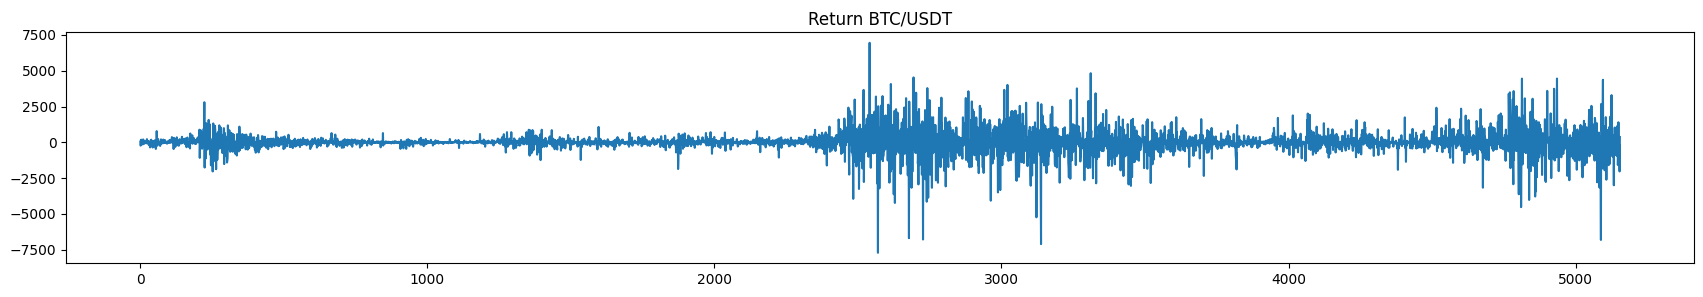

In [20]:
btcusdt_return.plot(figsize=(21, 3), title="Return BTC/USDT")
plt.show()

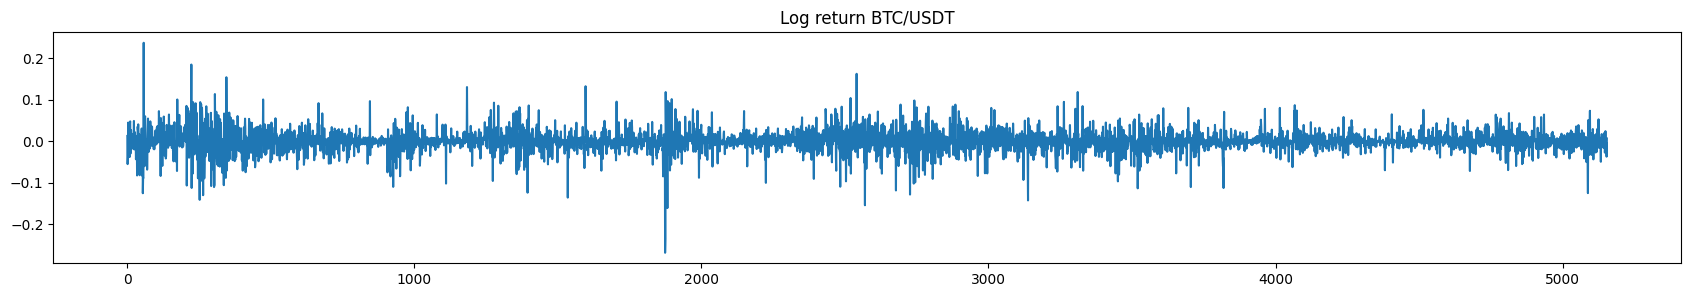

In [21]:
btcusdt_log_return.plot(figsize=(21, 3), title="Log return BTC/USDT")
plt.show()

#### Гистограммы данных и характеристи временных рядов

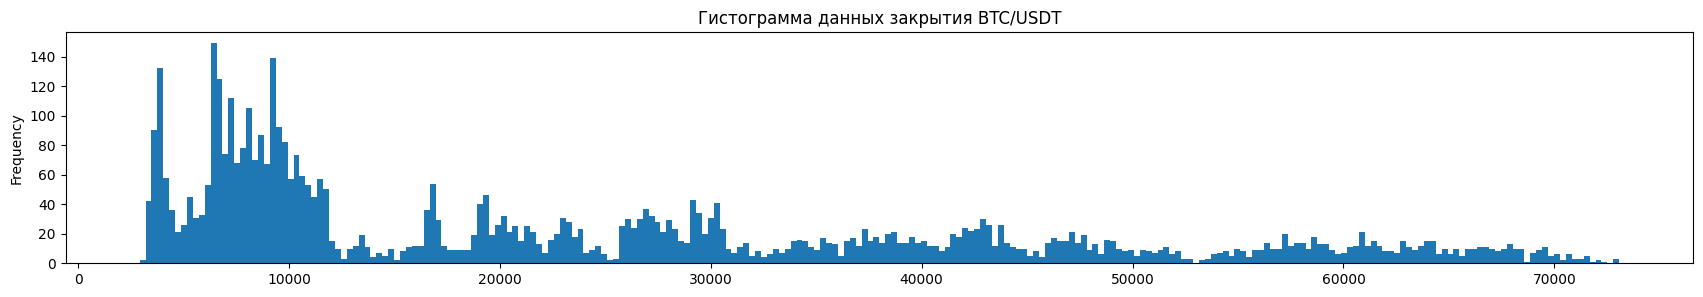

Close Mean: 24699.281817652765
Close STD: 19244.325121778635
Close Skew: 0.7891206424053663
Close Kurtosis: -0.5918874474237752
Close Excess kurtosis: -3.591887447423775


In [22]:
btcusdt_close.plot(kind="hist", figsize=(21, 3), title="Гистограмма данных закрытия BTC/USDT", bins=250)
plt.show()

print(f"Close Mean: {btcusdt_close.mean()}")
print(f"Close STD: {btcusdt_close.std()}")
print(f"Close Skew: {btcusdt_close.skew()}")
print(f"Close Kurtosis: {btcusdt_close.kurtosis()}")
print(f"Close Excess kurtosis: {btcusdt_close.kurtosis() - 3}")

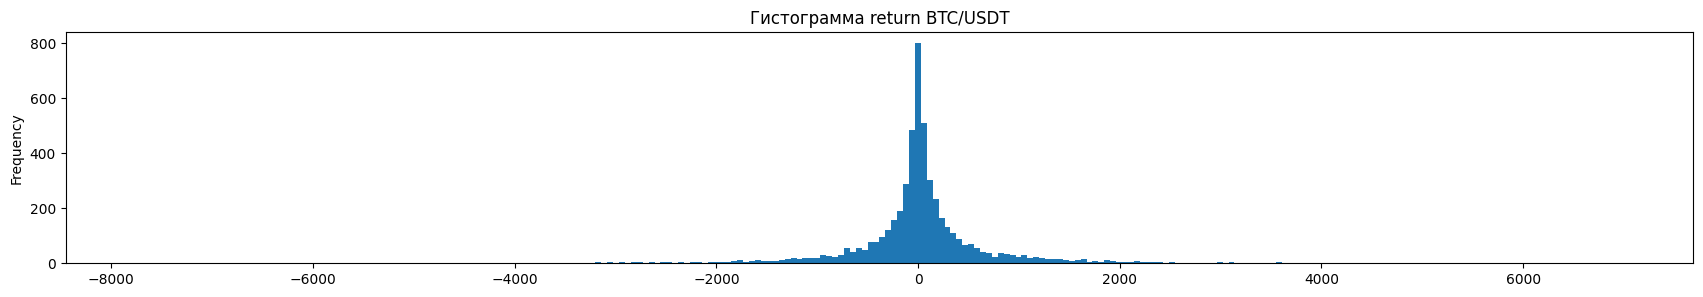

Return Mean: 9.710308498253783
Return STD: 760.8259296380916
Return Skew: -0.587822256151257
Return Kurtosis: 15.208054934530535
Return Excess kurtosis: 12.208054934530535


In [23]:
btcusdt_return.plot(kind="hist", figsize=(21, 3), title="Гистограмма return BTC/USDT", bins=250)
plt.show()

print(f"Return Mean: {btcusdt_return.mean()}")
print(f"Return STD: {btcusdt_return.std()}")
print(f"Return Skew: {btcusdt_return.skew()}")
print(f"Return Kurtosis: {btcusdt_return.kurtosis()}")
print(f"Return Excess kurtosis: {btcusdt_return.kurtosis() - 3}")

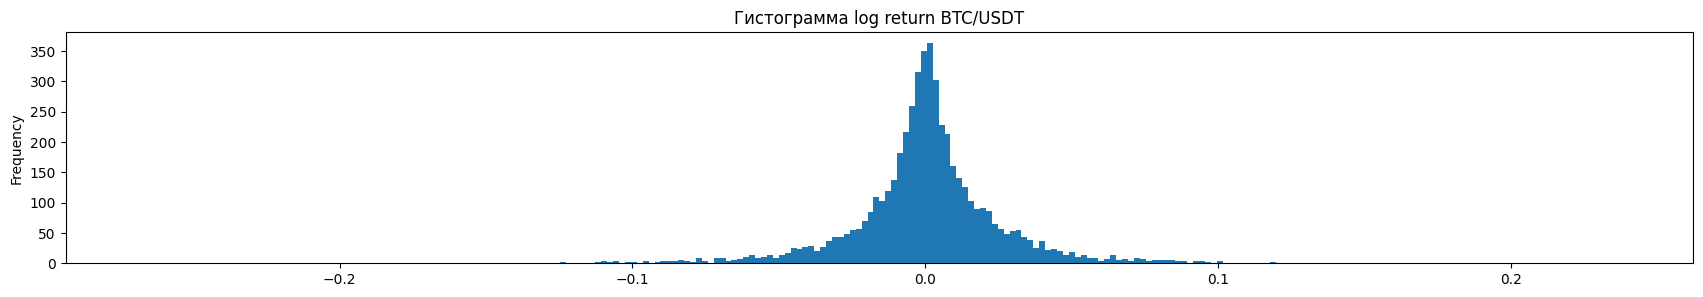

Log return Mean: 0.0004928161300659802
Log return STD: 0.026508806586330067
Log return Skew: -0.3622113836661129
Log return Kurtosis: 8.92468296404753
Log return Excess kurtosis: 5.9246829640475305


In [24]:
btcusdt_log_return.plot(kind="hist", figsize=(21, 3), title="Гистограмма log return BTC/USDT", bins=250)
plt.show()

print(f"Log return Mean: {btcusdt_log_return.mean()}")
print(f"Log return STD: {btcusdt_log_return.std()}")
print(f"Log return Skew: {btcusdt_log_return.skew()}")
print(f"Log return Kurtosis: {btcusdt_log_return.kurtosis()}")
print(f"Log return Excess kurtosis: {btcusdt_log_return.kurtosis() - 3}")

P.s. как можно увидеть на данный момент у BTC отрицательный Skew для данных return, что говорит о большем кол-во отрицательных изменений цен закрытия. Это плохо. Так же у распределений более тяжёлые хвосты, т.к. Excess kurtosis > 0, причём он (для данных return и log return) достаточно велик, что ведёт к более вероятным появлениям экстремальных значений BTC/USDT, что увеличивает рисковость данного актива

#### Boxplot данных

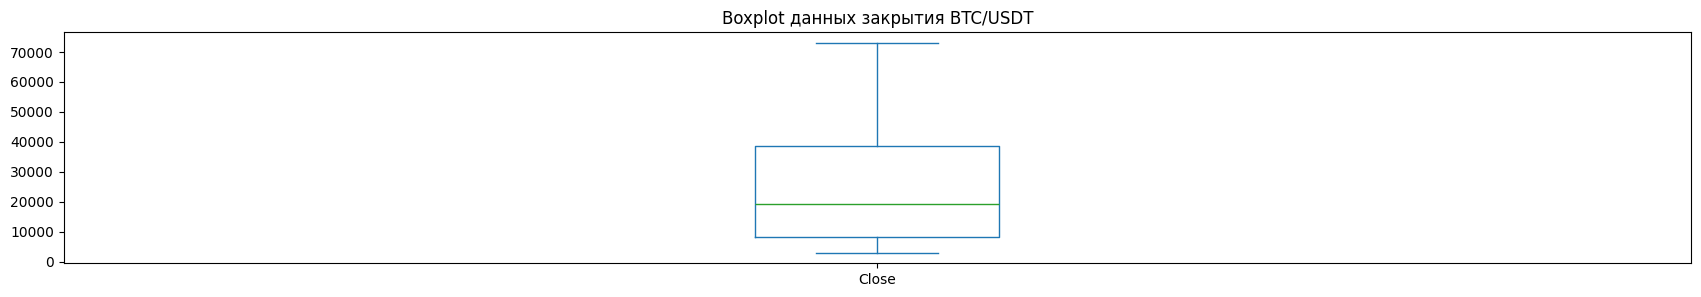

In [25]:
btcusdt_close.plot(kind="box", figsize=(21, 3), title="Boxplot данных закрытия BTC/USDT")
plt.show()

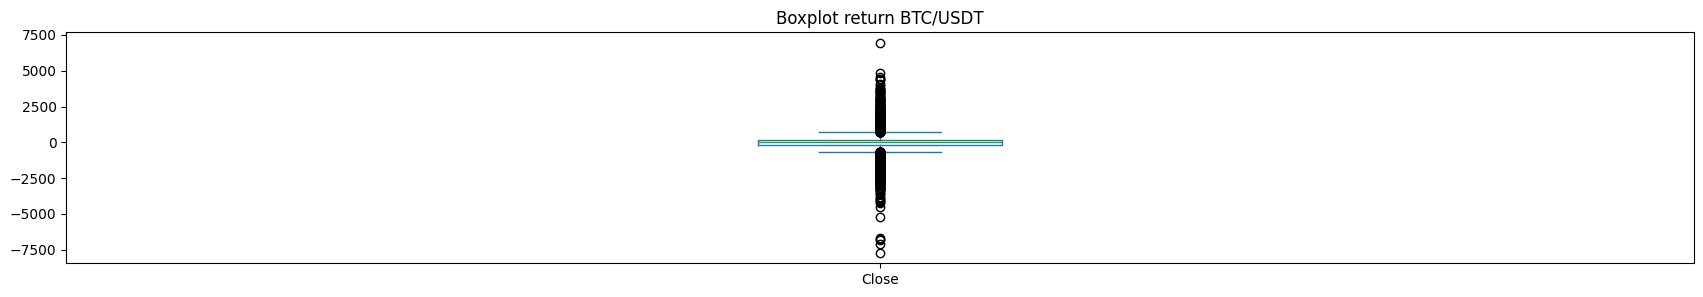

In [26]:
btcusdt_return.plot(kind="box", figsize=(21, 3), title="Boxplot return BTC/USDT")
plt.show()

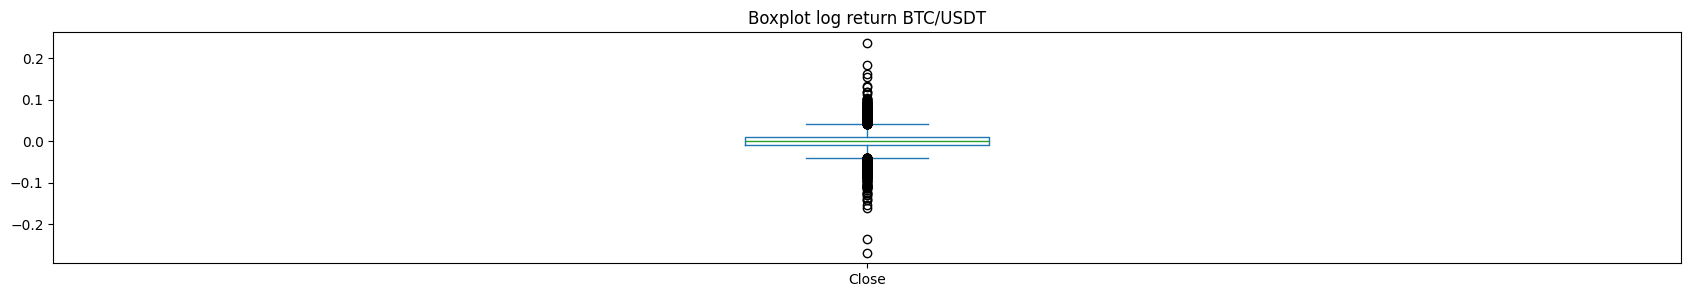

In [27]:
btcusdt_log_return.plot(kind="box", figsize=(21, 3), title="Boxplot log return BTC/USDT")
plt.show()

#### Проверка временных рядов на стационарность

In [28]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Test:")
    print(f"\tADF Statistic: {result[0]}")
    print(f"\tp-value: {result[1]}")
    for key, value in result[4].items():
        print(f"\tCritical Value {key}: {value}")
    if result[1] < 0.05:
        print("\tВременной ряд стационарен (отвергаем H0)\n")
    else:
        print("\tВременной ряд не стационарен (не отвергаем H0)\n")

In [29]:
def kpss_test(series):
    result = kpss(series, regression="c", nlags="auto")
    print("KPSS Test:")
    print(f"\tKPSS Statistic: {result[0]}")
    print(f"\tp-value: {result[1]}")
    for key, value in result[3].items():
        print(f"\tCritical Value {key}: {value}")
    if result[1] < 0.05:
        print("\tВременной ряд не стационарен (отвергаем H0)\n")
    else:
        print("\tВременной ряд стационарен (не отвергаем H0)\n")

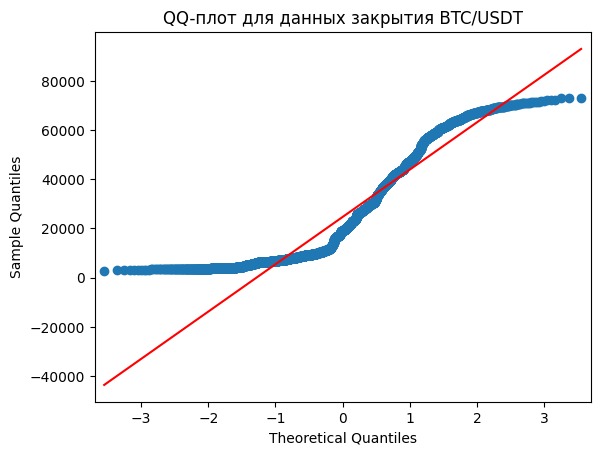

ADF Test:
	ADF Statistic: -1.1619916334301439
	p-value: 0.6897286361799047
	Critical Value 1%: -3.431621388447457
	Critical Value 5%: -2.8621018197215276
	Critical Value 10%: -2.5670690567160634
	Временной ряд не стационарен (не отвергаем H0)

KPSS Test:
	KPSS Statistic: 6.744832465314724
	p-value: 0.01
	Critical Value 10%: 0.347
	Critical Value 5%: 0.463
	Critical Value 2.5%: 0.574
	Critical Value 1%: 0.739
	Временной ряд не стационарен (отвергаем H0)



/tmp/ipykernel_33/3515296086.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="c", nlags="auto")


In [30]:
qqplot(btcusdt_close, line="s")
plt.title("QQ-плот для данных закрытия BTC/USDT")
plt.show()

adf_test(btcusdt_close)
kpss_test(btcusdt_close)

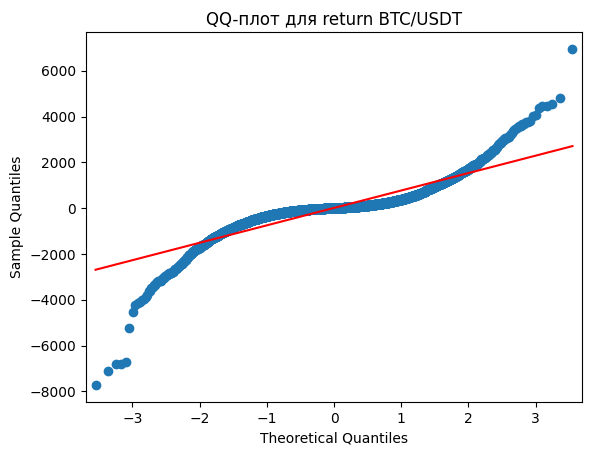

ADF Test:
	ADF Statistic: -25.000091747933315
	p-value: 0.0
	Critical Value 1%: -3.431621388447457
	Critical Value 5%: -2.8621018197215276
	Critical Value 10%: -2.5670690567160634
	Временной ряд стационарен (отвергаем H0)

KPSS Test:
	KPSS Statistic: 0.06676984754253673
	p-value: 0.1
	Critical Value 10%: 0.347
	Critical Value 5%: 0.463
	Critical Value 2.5%: 0.574
	Critical Value 1%: 0.739
	Временной ряд стационарен (не отвергаем H0)



/tmp/ipykernel_33/3515296086.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="auto")


In [31]:
qqplot(btcusdt_return.dropna(), line="s")
plt.title("QQ-плот для return BTC/USDT")
plt.show()

adf_test(btcusdt_return.dropna())
kpss_test(btcusdt_return.dropna())

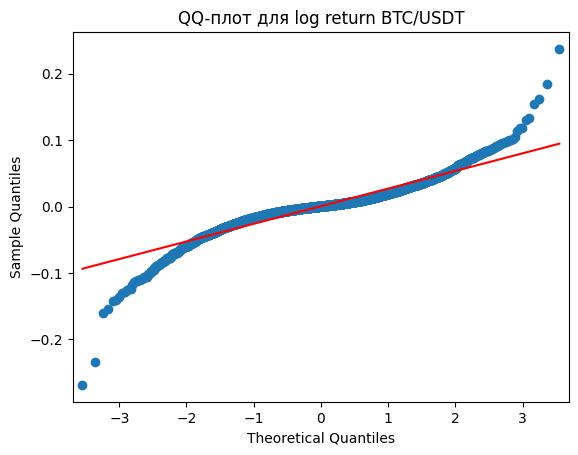

ADF Test:
	ADF Statistic: -35.31384717005212
	p-value: 0.0
	Critical Value 1%: -3.431620400468428
	Critical Value 5%: -2.8621013832321522
	Critical Value 10%: -2.5670688243566784
	Временной ряд стационарен (отвергаем H0)

KPSS Test:
	KPSS Statistic: 0.07385395176962695
	p-value: 0.1
	Critical Value 10%: 0.347
	Critical Value 5%: 0.463
	Critical Value 2.5%: 0.574
	Critical Value 1%: 0.739
	Временной ряд стационарен (не отвергаем H0)



/tmp/ipykernel_33/3515296086.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="auto")


In [32]:
qqplot(btcusdt_log_return.dropna(), line="s")
plt.title("QQ-плот для log return BTC/USDT")
plt.show()

adf_test(btcusdt_log_return.dropna())
kpss_test(btcusdt_log_return.dropna())

По проведенным тестам, можно сказать, что данные return и log return - стационарны и подходят под распределение T - Стьюдента. 

#### Gaussian Mixture Model

GMM позволит смоделировать многомадальные распределения. Так же у Gaussian Mixture более тяжёлые хвосты по сравнение с обычнам Gausian распределением

In [33]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import random

random.seed(0)
np.random.seed(0)

In [34]:
model = GaussianMixture(n_components=2)
model.fit(btcusdt_log_return.to_frame().dropna())

GaussianMixture(n_components=2)

In [35]:
print(f"weights: {model.weights_}")
print(f"means: {model.means_}")
print(f"covariances: {model.covariances_}" )

weights: [0.7704253 0.2295747]
means: [[ 0.00089681]
 [-0.00086293]]
covariances: [[[0.0001968 ]]

 [[0.00240189]]]


In [36]:
weights = model.weights_
means = model.means_.flatten()
covariances = model.covariances_.flatten()

In [37]:
x_list = np.linspace(btcusdt_log_return.min(), btcusdt_log_return.max(), 100)
fx0 = norm.pdf(x_list, means[0], np.sqrt(covariances[0]))
fx1 = norm.pdf(x_list, means[1], np.sqrt(covariances[1]))
fx = weights[0] * fx0 + weights[1] * fx1

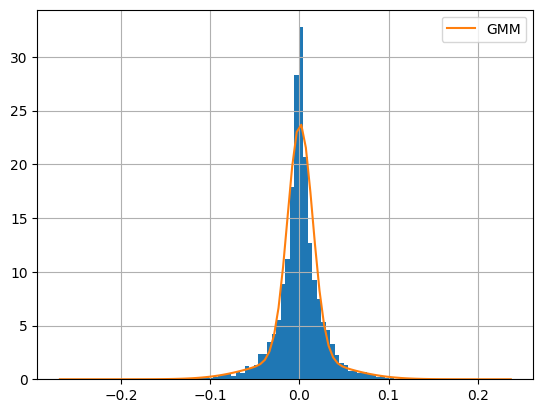

In [38]:
btcusdt_log_return.hist(bins=100, density=True)
plt.plot(x_list, fx, label="GMM")
plt.legend()
plt.show()

Как видно GMM способна примерно определить распределение данных, по этому её можно использовать в наших данных (например в определении режима рынка и т.п.)

P.s. ```n_components = 2``` было взято для примера. Оптимальное кол-во n_components требуется определять с помощью информационных критериев AIC, BIC. Больше информации тут: https://medium.com/@tballz/regime-detection-and-prediction-in-financial-markets-lesson-2-application-of-gaussian-mixture-5ee6c0199676

#### ACF, PACF

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

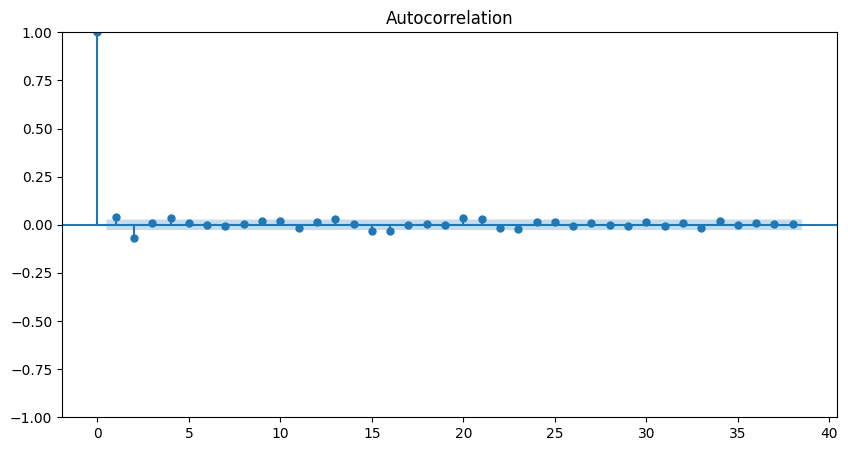

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(btcusdt_log_return.dropna(), ax=ax)
plt.show()

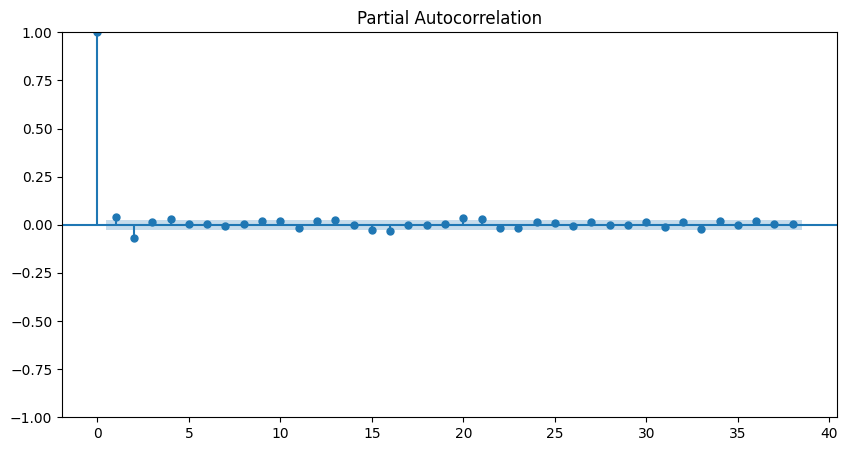

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(btcusdt_log_return.dropna(), ax=ax)
plt.show()

Как всегда, у ACF и PACF всё плохо. По данным визуализациям мы должны создать ARIMA(0, 1, 0), что является случайным блужданием

### Анализ данных паттренов

#### Визуализация данных

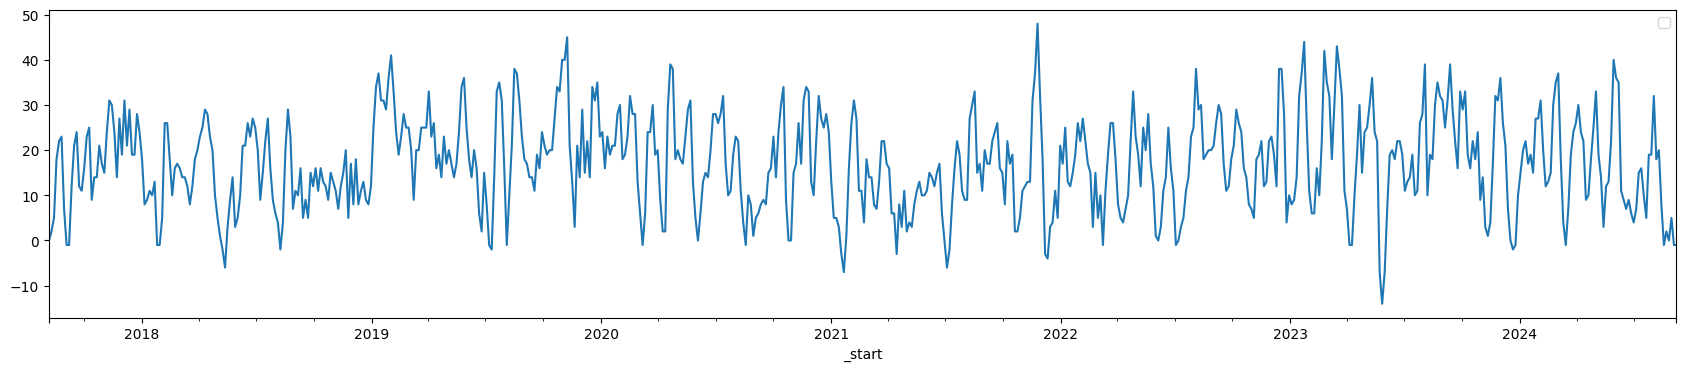

In [42]:
patterns_result.plot(x="_start", y="_value", figsize=(21, 4))
plt.show()

#### Гистограммы данных

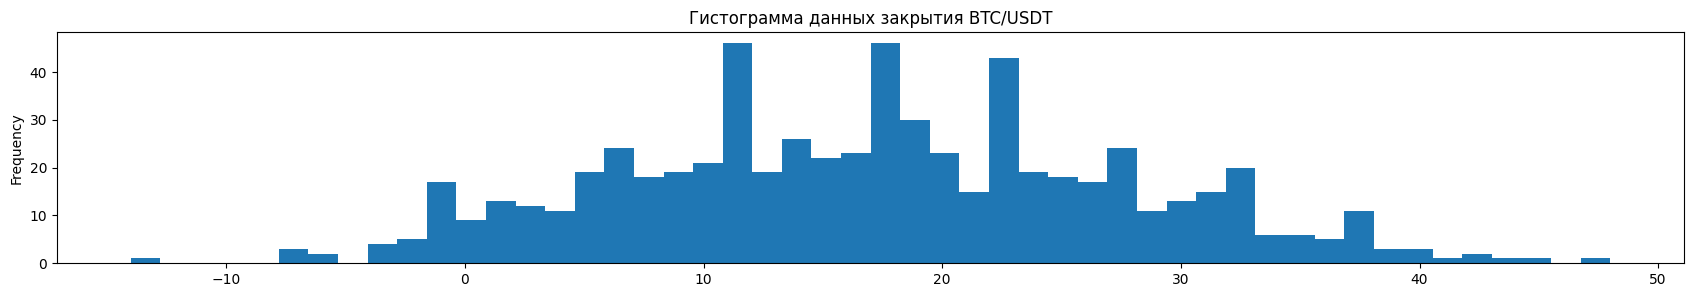

Close Mean: 17.09722222222222
Close STD: 10.465434014841946
Close Skew: 0.10461488331767951
Close Kurtosis: -0.3785652431954438


In [43]:
patterns_result["_value"].plot(kind="hist", figsize=(21, 3), title="Гистограмма данных закрытия BTC/USDT", bins=50)
plt.show()

print(f"Close Mean: {patterns_result['_value'].mean()}")
print(f"Close STD: {patterns_result['_value'].std()}")
print(f"Close Skew: {patterns_result['_value'].skew()}")
print(f"Close Kurtosis: {patterns_result['_value'].kurtosis()}")

#### Boxplot данных

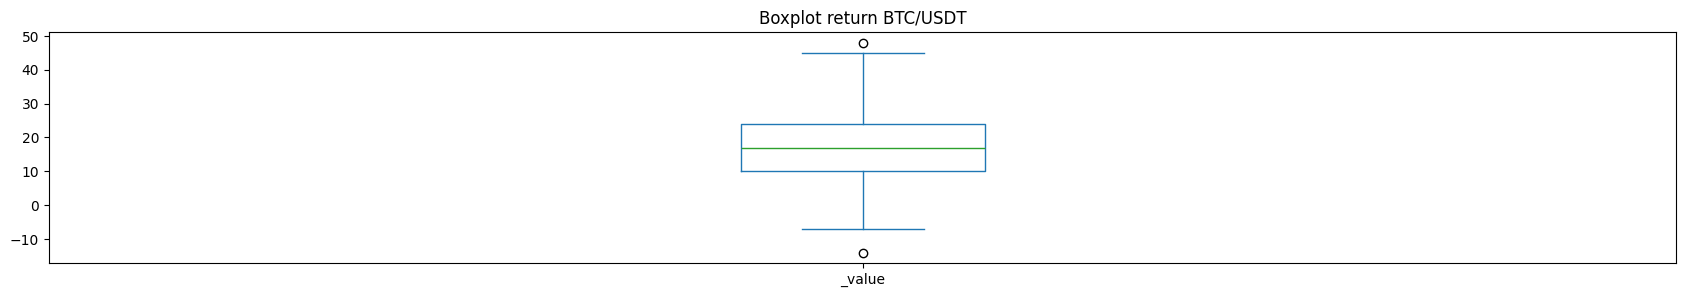

In [44]:
patterns_result["_value"].plot(kind="box", figsize=(21, 3), title="Boxplot return BTC/USDT")
plt.show()

#### Описание данных

In [45]:
patterns_result["_value"].describe()

count    648.000000
mean      17.097222
std       10.465434
min      -14.000000
25%       10.000000
50%       17.000000
75%       24.000000
max       48.000000
Name: _value, dtype: float64

## Подборка параметров для стратегии

Ниже представлены параметры, которые были объявлены до этого пункта

In [162]:
TIMEFRAME_FOR_STRATEGY

'12h'

In [163]:
WINDOW_PERIOD, WINDOW_EVERY

('12d', '4d')

Кол-во покупаемых активов при торговле

In [201]:
INSTRUMENT_COUNT = 1

Подбор пороговых значений, для открытия long позиций и их закрытия

In [164]:
PATTERNS_CLOSE_THRESHOLD = patterns_result["_value"].quantile(0.2)
PATTERNS_LONG_THRESHOLD = patterns_result["_value"].quantile(0.8)

PATTERNS_CLOSE_THRESHOLD, PATTERNS_LONG_THRESHOLD

(8.0, 26.0)

Построим визуализации индикатора на основе паттернов тех анализа и границы при которых будут открываться long и short позиции

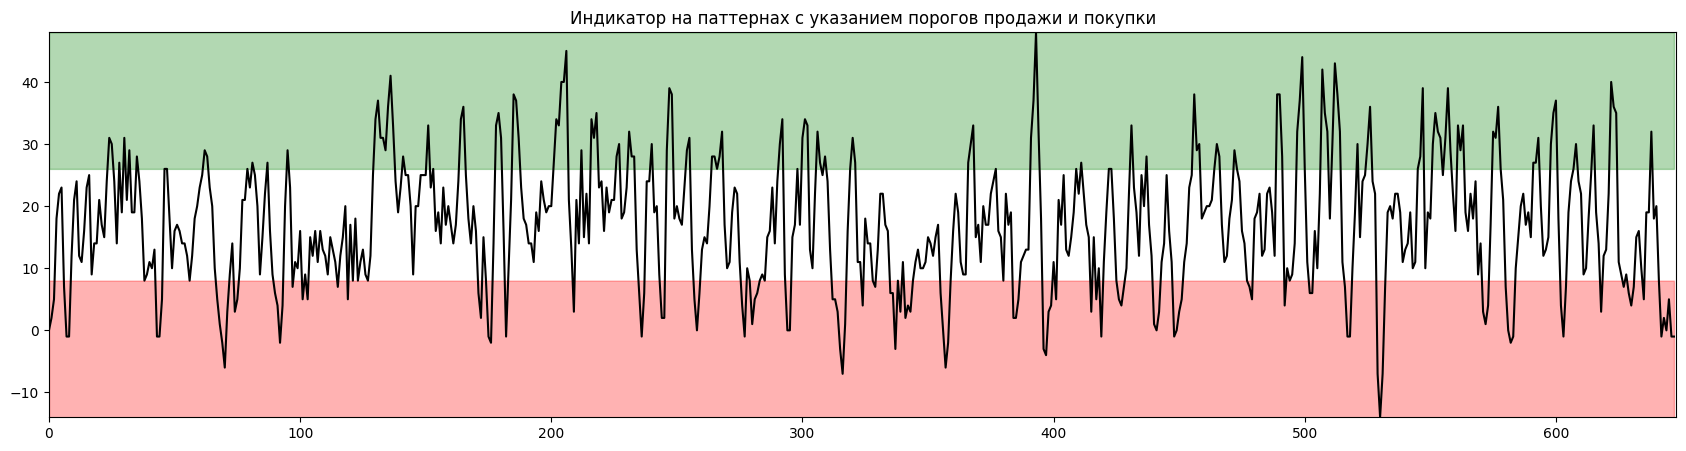

In [165]:
# Создание графика
plt.figure(figsize=(21, 5))
plt.plot(patterns_result["_value"], label="Data", color="black")

plt.fill_between(patterns_result["_value"].index, patterns_result["_value"].min(), PATTERNS_CLOSE_THRESHOLD, color='red', alpha=0.3, label='Close long')
plt.fill_between(patterns_result["_value"].index, PATTERNS_LONG_THRESHOLD, patterns_result["_value"].max(), color='green', alpha=0.3, label='Long')

plt.xlim(0, patterns_result["_value"].shape[0])
plt.ylim(patterns_result["_value"].min(), patterns_result["_value"].max())
plt.title("Индикатор на паттернах с указанием порогов продажи и покупки")
plt.show()

Параметр определяющий, открыта ли long позиция

In [166]:
# Стратегия после покупки не может снова покупать, только продавать, аналогично с продажей
IS_ACTIVE_TRADE = False

## Разработка алгоритма стратегии

In [167]:
ohlc = ohlcv[["Date", "Close", "High", "Low", "Open"]].copy()
# Создадим новый стобец для осуществление торгов. Если -1, то зыкрытие long позиции, если 1, то long, если 0 то бездействие
ohlc["Trade"] = 0

Данные OHLC для BTC/USDT

In [168]:
ohlc.head(4)

,Date,Close,High,Low,Open,Trade
0,2017-08-17 12:00:00+00:00,4285.08,4485.39,4200.74,4436.06,0
1,2017-08-18 00:00:00+00:00,4340.31,4371.52,4134.61,4285.08,0
2,2017-08-18 12:00:00+00:00,4108.37,4340.31,3938.77,4320.52,0
3,2017-08-19 00:00:00+00:00,3957.60,4184.69,3850.00,4108.37,0


In [169]:
ohlc.tail(4)

,Date,Close,High,Low,Open,Trade
5151,2024-09-05 12:00:00+00:00,56180.00,57350.00,55643.65,56698.01,0
5152,2024-09-06 00:00:00+00:00,55999.09,56858.88,55280.00,56180.00,0
5153,2024-09-06 12:00:00+00:00,53962.97,57008.00,52550.00,55999.09,0
5154,2024-09-07 00:00:00+00:00,54332.01,54419.38,53745.54,53962.97,0


Агрегированные данные о паттернах

In [170]:
# Переименнуем колонку времени
patterns_result = patterns_result.rename(columns={"_start": "Date"})

In [171]:
patterns_result.head(4)

,result,table,Date,_value
0,_result,0,2017-08-06 00:00:00+00:00,0
1,_result,1,2017-08-10 00:00:00+00:00,2
2,_result,2,2017-08-14 00:00:00+00:00,5
3,_result,3,2017-08-18 00:00:00+00:00,18


In [172]:
patterns_result.tail(4)

,result,table,Date,_value
644,_result,644,2024-08-25 00:00:00+00:00,0
645,_result,645,2024-08-29 00:00:00+00:00,5
646,_result,646,2024-09-02 00:00:00+00:00,-1
647,_result,647,2024-09-06 00:00:00+00:00,-1


Получаем время, которое общее между этими двумя DataFrame

In [173]:
total_time = pd.merge(ohlc[["Date"]], patterns_result[["Date"]], on="Date").squeeze()

In [174]:
total_time

0     2017-08-18 00:00:00+00:00
1     2017-08-22 00:00:00+00:00
2     2017-08-26 00:00:00+00:00
3     2017-08-30 00:00:00+00:00
4     2017-09-03 00:00:00+00:00
                 ...           
640   2024-08-21 00:00:00+00:00
641   2024-08-25 00:00:00+00:00
642   2024-08-29 00:00:00+00:00
643   2024-09-02 00:00:00+00:00
644   2024-09-06 00:00:00+00:00
Name: Date, Length: 645, dtype: datetime64[ns, UTC]

Основной цикл стратегии

In [220]:
buy_price = 0
stratagy_profit = 0
profits = []
longs_datetime = []
shorsts_datetime = []

for time in total_time:
    # Ищем строку с подходящим временем
    pattern_data = patterns_result[patterns_result["Date"] == time].values[0]
    # Получаем нужную информацию из строчки данных
    pattern_indicator_value = pattern_data[-1]
    pattern_indicator_time = pattern_data[-2]

    # Действия стратегии
    # Открытие long позиции на споте
    if (IS_ACTIVE_TRADE is False) and (pattern_indicator_value > PATTERNS_LONG_THRESHOLD):
        ohlc.loc[ohlc[ohlc["Date"] == time].index, "Trade"] = 1
        buy_price = ohlc[ohlc["Date"] == time]["Close"].values[0]
        longs_datetime += [time]
        IS_ACTIVE_TRADE = True
        
    # Закрытие long позиции на споте
    elif (IS_ACTIVE_TRADE is True) and (pattern_indicator_value < PATTERNS_CLOSE_THRESHOLD):
        ohlc.loc[ohlc[ohlc["Date"] == time].index, "Trade"] = -1
        stratagy_profit += ohlc[ohlc["Date"] == time]["Close"].values[0] - buy_price
        profits += [ohlc[ohlc["Date"] == time]["Close"].values[0] - buy_price]
        shorsts_datetime += [time]
        IS_ACTIVE_TRADE = False
        
    else:
        pass

# Обрезка массива времени по оконченным сделкам
longs_datetime = longs_datetime[:len(shorsts_datetime)]

Замерим время исполнения цикла

In [246]:
%%timeit -r 10 -n 10

# Константы перенесенные для замерения времени
IS_ACTIVE_TRADE = False

buy_price = 0
stratagy_profit = 0
profits = []
longs_datetime = []
shorsts_datetime = []

for time in total_time:
    # Ищем строку с подходящим временем
    pattern_data = patterns_result[patterns_result["Date"] == time].values[0]
    # Получаем нужную информацию из строчки данных
    pattern_indicator_value = pattern_data[-1]
    pattern_indicator_time = pattern_data[-2]

    # Действия стратегии
    # Открытие long позиции на споте
    if (IS_ACTIVE_TRADE is False) and (pattern_indicator_value > PATTERNS_LONG_THRESHOLD):
        ohlc.loc[ohlc[ohlc["Date"] == time].index, "Trade"] = 1
        buy_price = ohlc[ohlc["Date"] == time]["Close"].values[0]
        longs_datetime += [time]
        IS_ACTIVE_TRADE = True
        
    # Закрытие long позиции на споте
    elif (IS_ACTIVE_TRADE is True) and (pattern_indicator_value < PATTERNS_CLOSE_THRESHOLD):
        ohlc.loc[ohlc[ohlc["Date"] == time].index, "Trade"] = -1
        stratagy_profit += ohlc[ohlc["Date"] == time]["Close"].values[0] - buy_price 
        profits += [ohlc[ohlc["Date"] == time]["Close"].values[0] - buy_price]
        shorsts_datetime += [time]
        IS_ACTIVE_TRADE = False
        
    else:
        pass

# Обрезка массива времени по оконченным сделкам
longs_datetime = longs_datetime[:len(shorsts_datetime)]

371 ms ± 16.8 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Простое бэк тестирование стратегии

Визуальное представление

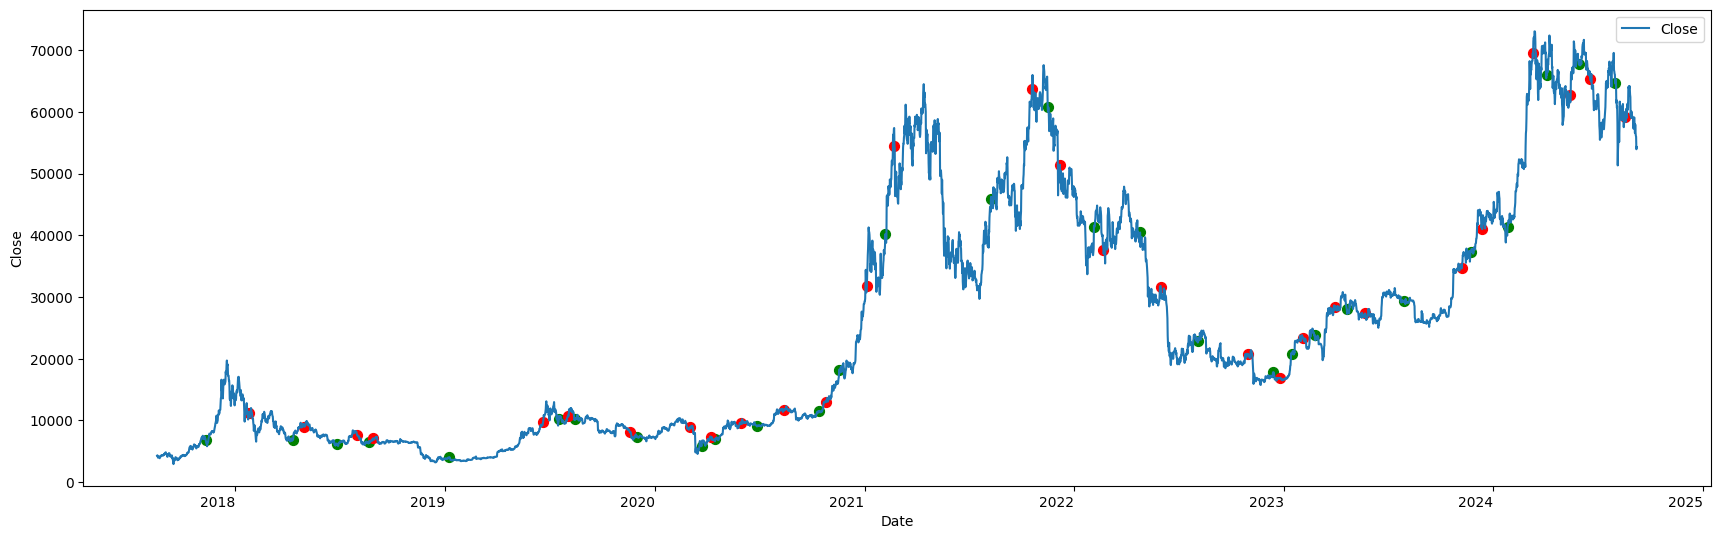

In [200]:
fig, ax = plt.subplots(figsize=(21, 7))

ohlc.plot(ax=ax, x="Date", y="Close")
ohlc[ohlc["Trade"] == 1].plot(ax=ax, kind="scatter", x="Date", y="Close", c="green", s=50)
ohlc[ohlc["Trade"] == -1].plot(ax=ax, kind="scatter", x="Date", y="Close", c="red", s=50)

plt.show()

In [213]:
print(f"Итоговая выручка стратегии: {stratagy_profit}")

Итоговая выручка стратегии: 75195.90000000002


In [230]:
stratagy_profits_per_deal = pd.DataFrame({
    "DealStartDate": longs_datetime,
    "DealEndDate": shorsts_datetime,
    "ProfitOfDeal": profits
})

In [231]:
stratagy_profits_per_deal

,DealStartDate,DealEndDate,ProfitOfDeal
0,2017-11-10 00:00:00+00:00,2018-01-25 00:00:00+00:00,4383.80
1,2018-04-11 00:00:00+00:00,2018-05-01 00:00:00+00:00,2123.04
2,2018-06-26 00:00:00+00:00,2018-08-01 00:00:00+00:00,1338.18
3,2018-08-21 00:00:00+00:00,2018-08-29 00:00:00+00:00,658.88
4,2019-01-08 00:00:00+00:00,2019-06-21 00:00:00+00:00,5807.30
5,2019-07-19 00:00:00+00:00,2019-08-04 00:00:00+00:00,385.91
6,2019-08-16 00:00:00+00:00,2019-11-20 00:00:00+00:00,-2060.51
7,2019-12-02 00:00:00+00:00,2020-03-03 00:00:00+00:00,1560.31
8,2020-03-23 00:00:00+00:00,2020-04-08 00:00:00+00:00,1449.63
9,2020-04-16 00:00:00+00:00,2020-05-30 00:00:00+00:00,2530.18


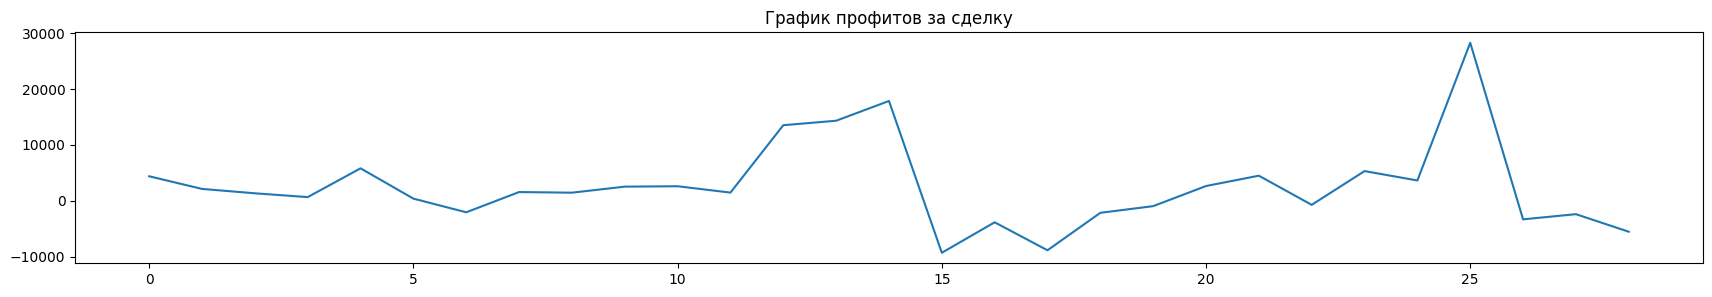

In [242]:
stratagy_profits_per_deal["ProfitOfDeal"].plot(figsize=(21, 3), title="График профитов за сделку")
plt.show()

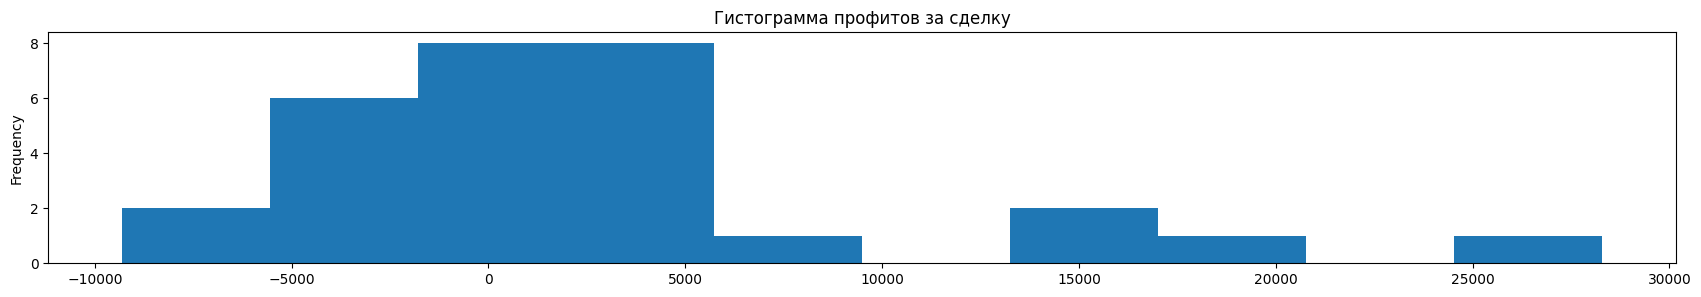

In [243]:
stratagy_profits_per_deal["ProfitOfDeal"].plot(figsize=(21, 3), title="Гистограмма профитов за сделку", kind="hist")
plt.show()

Как можно увидеть данная стратегия крайне нестабильна, но приносит профит. Этот ноутбук был создан для того, чтобы разработать базу стратегии. Далее в ```strategy_optimization.ipynb``` стратегия будет доработана и оптимизирована под различные таймфреймы